In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('grade3', context='talk', grid=False, ticks=True, fscale=1.5)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

In [29]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'O_1s_(2)' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49, 'Ba_3d_5/2' : 7.49, 'Ba_3d_3/2' : 5.20,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba_4d': 2.35, 'Na_1s' : 1.685, 'Cl_2s' : 0.37, 'Fe_2p': 2.957,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl_2p' : 0.891, 'Si2p': 0.339})

asf2 = {'Ba_3d_5/2' : 25.8, 'Ba_3d_3/2': 17.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.69}

asf3 = {'Ba_3d_5/2' : 64.3, 'Ba_3d_3/2': 49.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.50}

# Import data

In [10]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au_Mica/2021_10_01_FBI_Au_mica/'
files = glob.glob(path+'/**/*.uxy')
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/Au_Mica/2021_10_01_FBI_Au_mica/proc/20211001_AuMica_FBI_subl_45min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_Mica/2021_10_01_FBI_Au_mica/proc/20211001_AuMica_FBI_subl_45min_FeCl2_1ML.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_Mica/2021_10_01_FBI_Au_mica/proc/20211001_AuMica_clean.uxy']

In [22]:
unscaled = [read_processed_xp(f) for f in files]

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_Mica/2021_10_01_FBI_Au_mica/proc/20211001_AuMica_FBI_subl_45min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_Mica/2021_10_01_FBI_Au_mica/proc/20211001_AuMica_FBI_subl_45min_FeCl2_1ML.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_Mica/2021_10_01_FBI_Au_mica/proc/20211001_AuMica_clean.uxy.ft', returning empty fit dict


## Subtract bg from FBIG3_subl_27min (sparky)

In [36]:
file = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/20211020_AuMica_FBIG3_subl_27min_BaCl2_100s.fxy'
sparky = read_processed_xp(file)

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/20211020_AuMica_FBIG3_subl_27min_BaCl2_100s.fxy.ft', returning empty fit dict


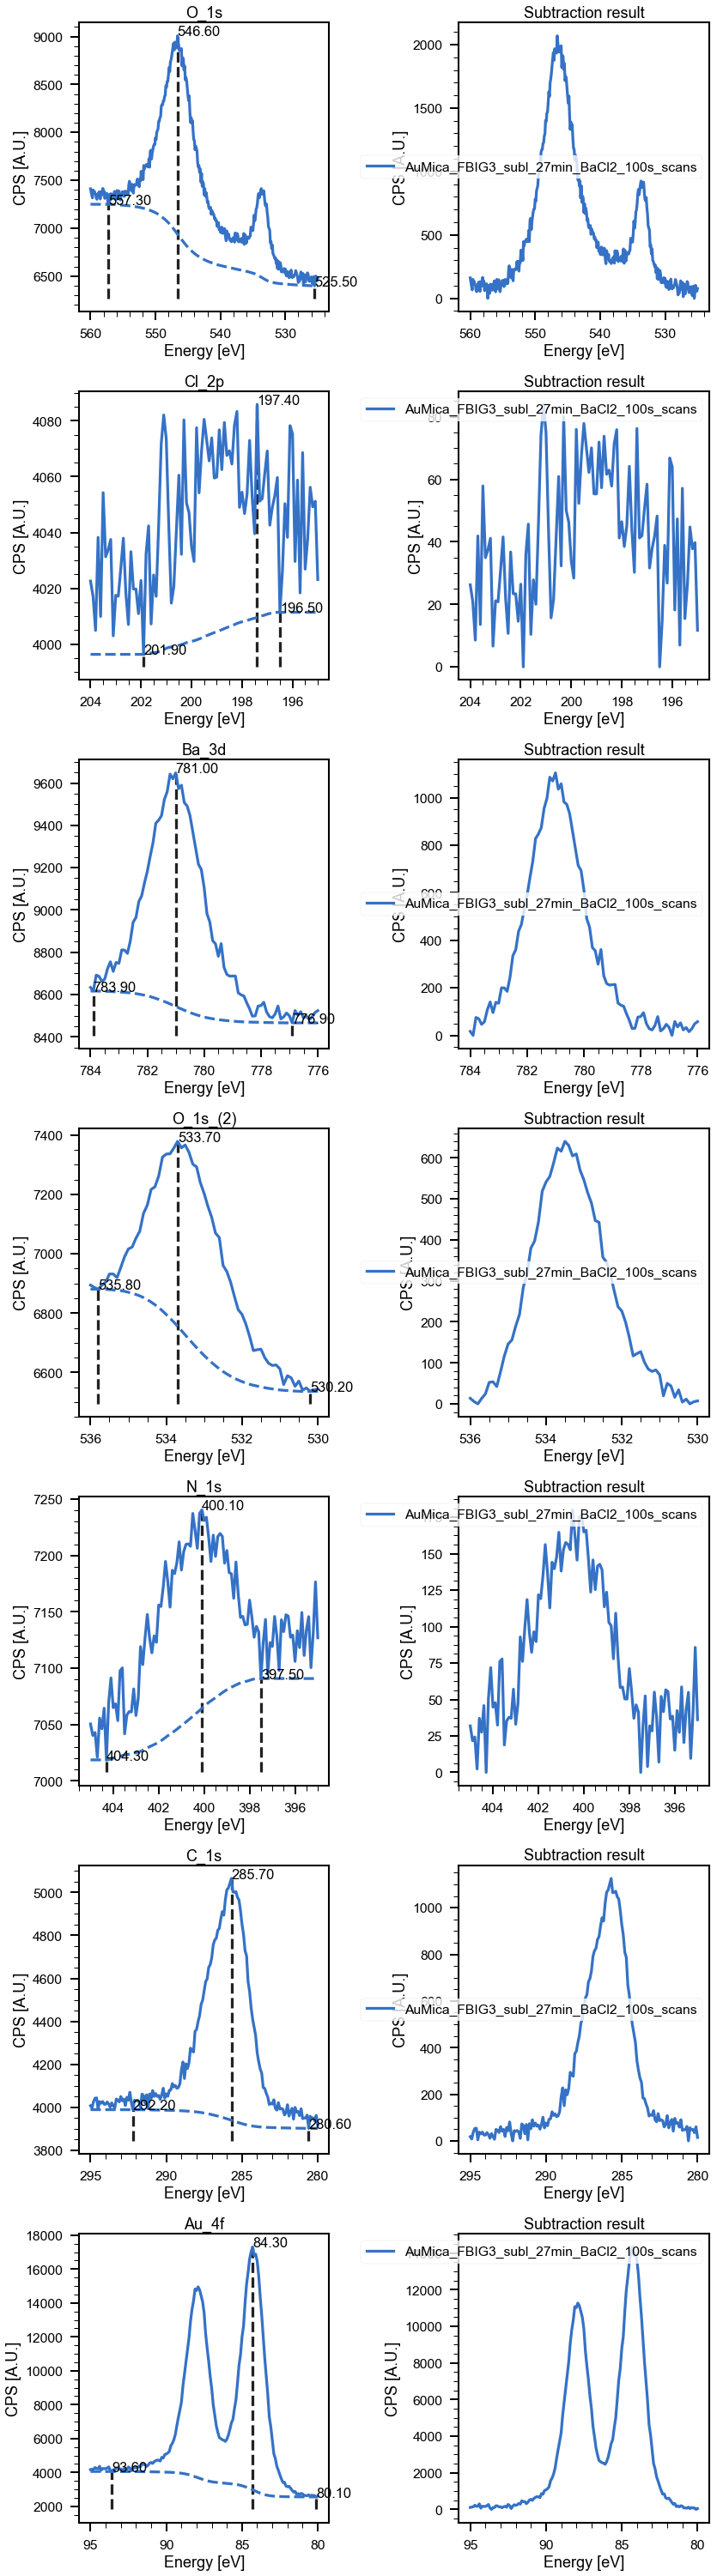

In [37]:
regs = [ 'O_1s', 'Cl_2p', 'Ba_3d', 'O_1s_(2)', 'N_1s', 'C_1s', 'Au_4f']
sparky = bulk_bg_subtract([sparky], regs)[0]

In [39]:
write_processed_xp(sparky.path., sparky)

In [38]:
sparky.name = sparky.name.replace('_scans', '')

## Plot regions

In [21]:
unscaled[1].name#.dfx.columns.levels[0]

'AuMica_FBI_subl_45min_FeCl2_1ML'

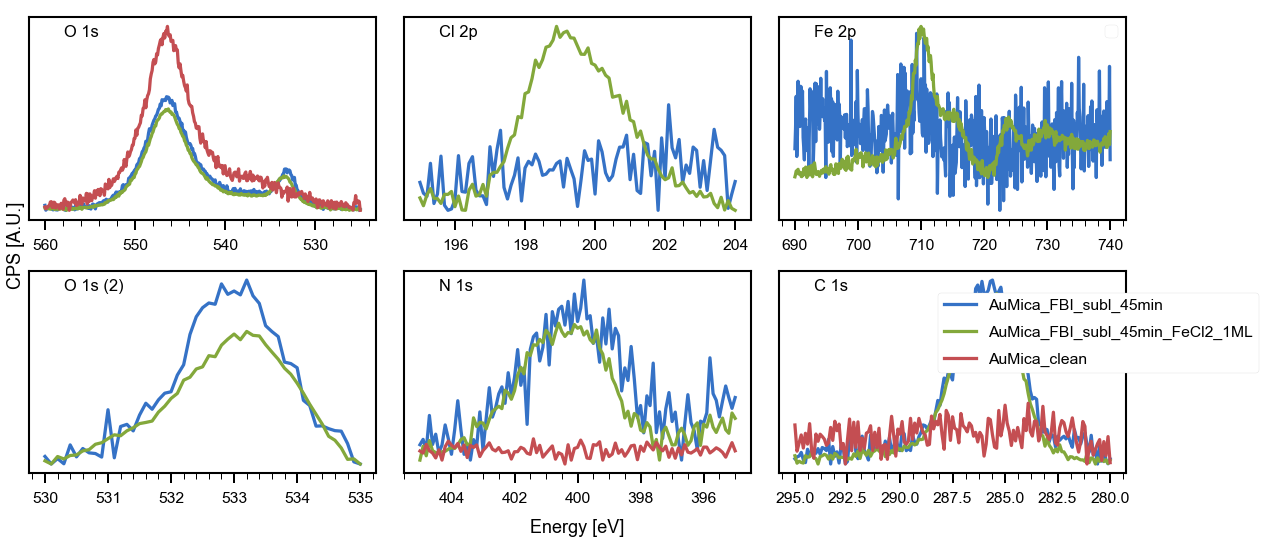

In [23]:
regs = [ 'O_1s', 'Cl_2p', 'Fe_2p', 'O_1s_(2)', 'N_1s', 'C_1s']
plot_xp_regions(unscaled, regs);

# Stoichiometry

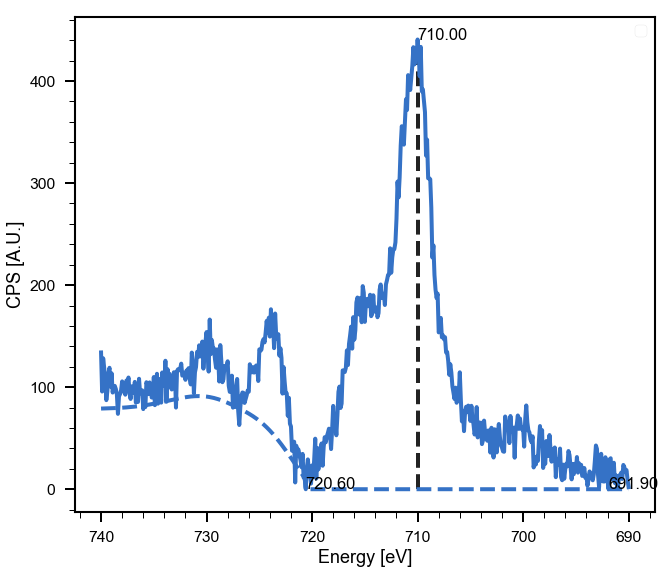

In [67]:
unscaled[1] = subtract_ALShirley_bg(unscaled[1], 'Fe_2p');

'Cl_2p' region does not exist in AuMica_clean
'Fe_2p' region does not exist in AuMica_clean
'O_1s_(2)' region does not exist in AuMica_clean


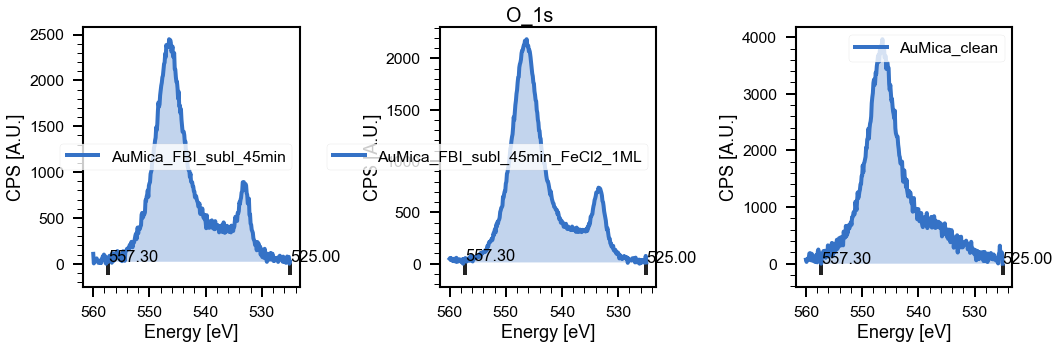

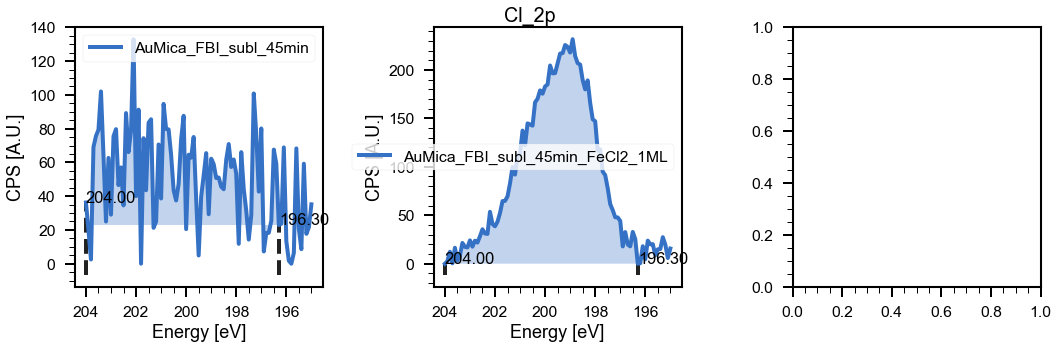

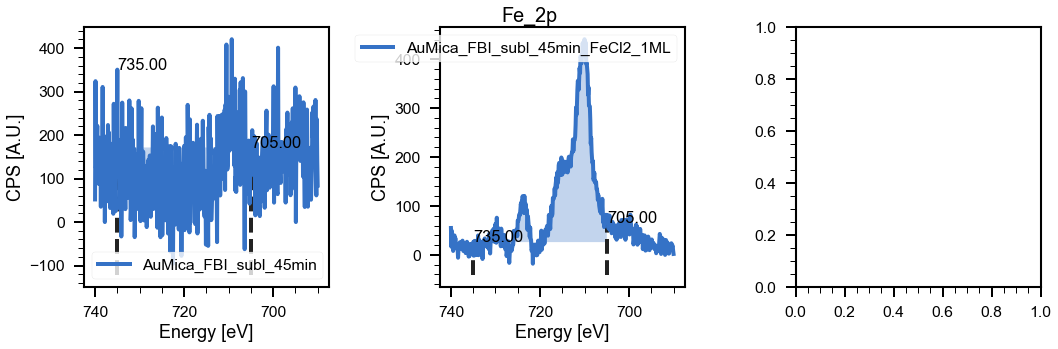

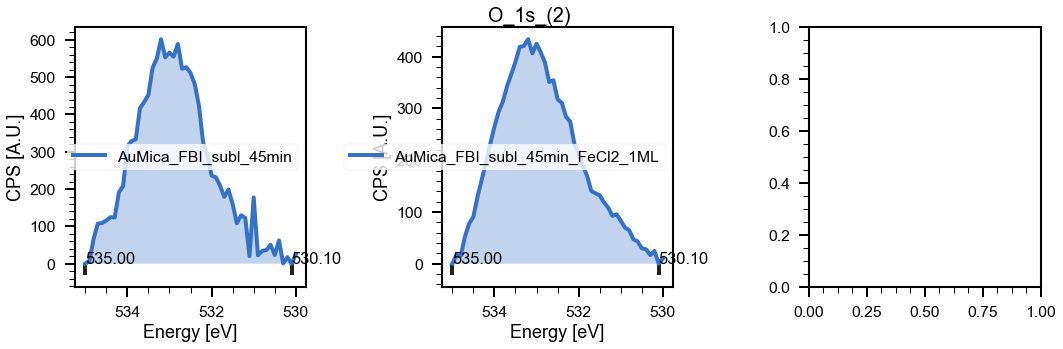

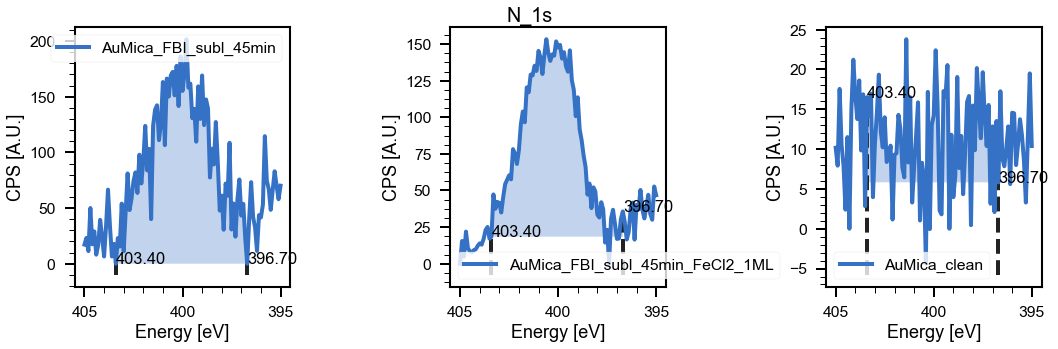

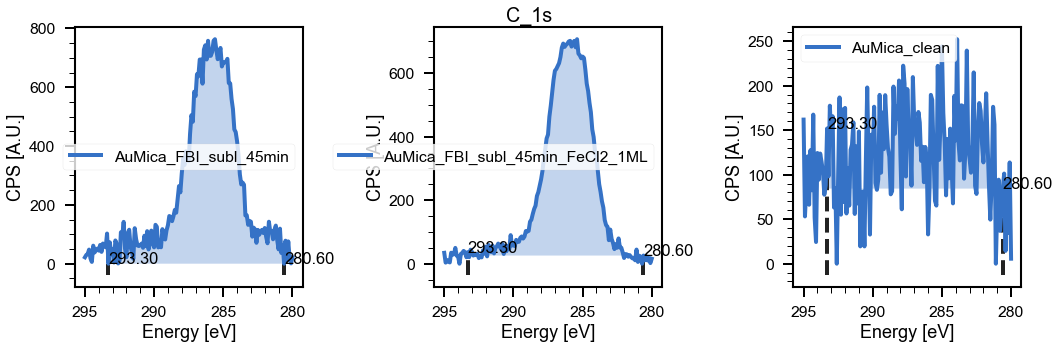

In [77]:
for r in regs:
    if r == 'Fe_2p':
        integrateRegions(unscaled, r, asf=asf, edw=705, eup=735)
    else:
        integrateRegions(unscaled, r, asf=asf)

In [25]:
asto = {'C_1s': 31, 'O_1s_(2)':5, 'N_1s':3, 'Fe_2p': 1e-10, 'Cl_2p':1e-10}
sto = XPS_experiment(name='Stoichiometry FBI-G3', area=asto)

In [78]:
g1 = [unscaled[i] for i in [0]]
g1fe = [unscaled[j] for j in [1]]
for xp in g1fe:
    xp.area['FBI-g1'] = xp.area['N_1s']/3

num = ['C_1s', 'C_1s', 'O_1s_(2)', 'Fe_2p', 'Cl_2p']
denom = ['O_1s_(2)', 'N_1s', 'N_1s', 'N_1s', 'Fe_2p']
display_stoichiometry(g1 + [sto], num[:-2], denom[:-2])
display_stoichiometry(g1fe, num + ['Fe_2p'], denom + ['FBI-g1'])

# Coverage

In [145]:
inds = [[0, 2]]
arrange_coverages(unscaled, inds, r_ml=1.1, region='Au_4f', mfp=3.87, takeoff=10)

matrix([[1.08305296, 0.01864886]])

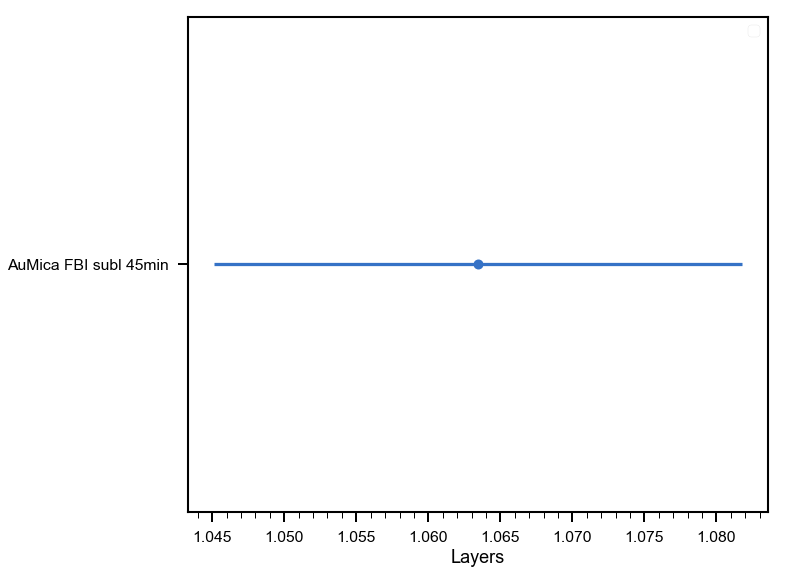

In [38]:
plot_coverages(g1)

# Plot raw compare w/ and w/out Fe++

In [86]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au_mica/2021_10_01_FBI_Au_mica/'
files = glob.glob(path+'/*.xy')
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/Au_mica/2021_10_01_FBI_Au_mica/20210906_FeCl2_Au111_4AA.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica/2021_10_01_FBI_Au_mica/20211001_AuMica_FBI_subl_45min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica/2021_10_01_FBI_Au_mica/20211001_AuMica_FBI_subl_45min_FeCl2_1ML.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica/2021_10_01_FBI_Au_mica/20211001_AuMica_clean.xy']

In [89]:
raw = [xps_data_import(f) for f in files[1:]]

In [127]:
pathFe = '/Users/pabloherrero/sabat/xps_spectra/Au_Mica/2021_10_01_FBI_Au_mica/20210906_FeCl2_Au111_4AA.xy'
groups = import_group_xp(pathFe)
raw.append(groups[1])

In [128]:
[xp.name for xp in raw]

['FBI-G1, 1.0 ML',
 'FBI-G1-FeCl$_2$, $\\phi$ = 2.81',
 'AuMica_clean',
 'FeCl2_4AA',
 'FeCl2_2AA']

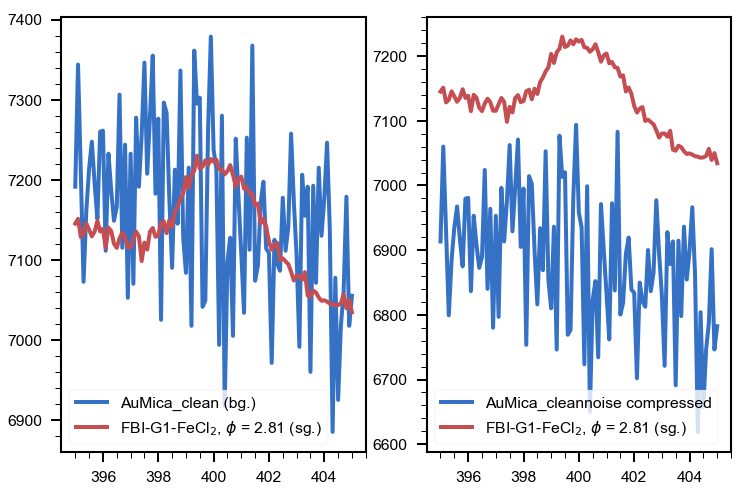

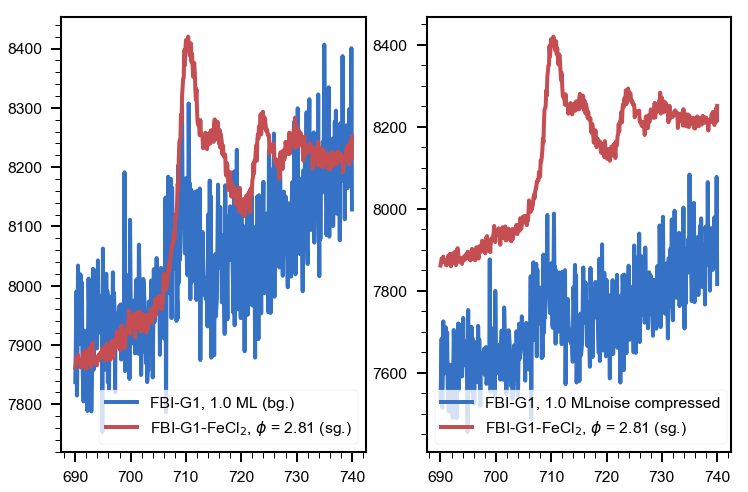

In [96]:
raw[2].color='k'
raw[3].color='r'
compress_noisy_region(raw[2], raw[1], 'N_1s', inplace=True);
compress_noisy_region(raw[0], raw[1], 'Fe_2p', inplace=True);

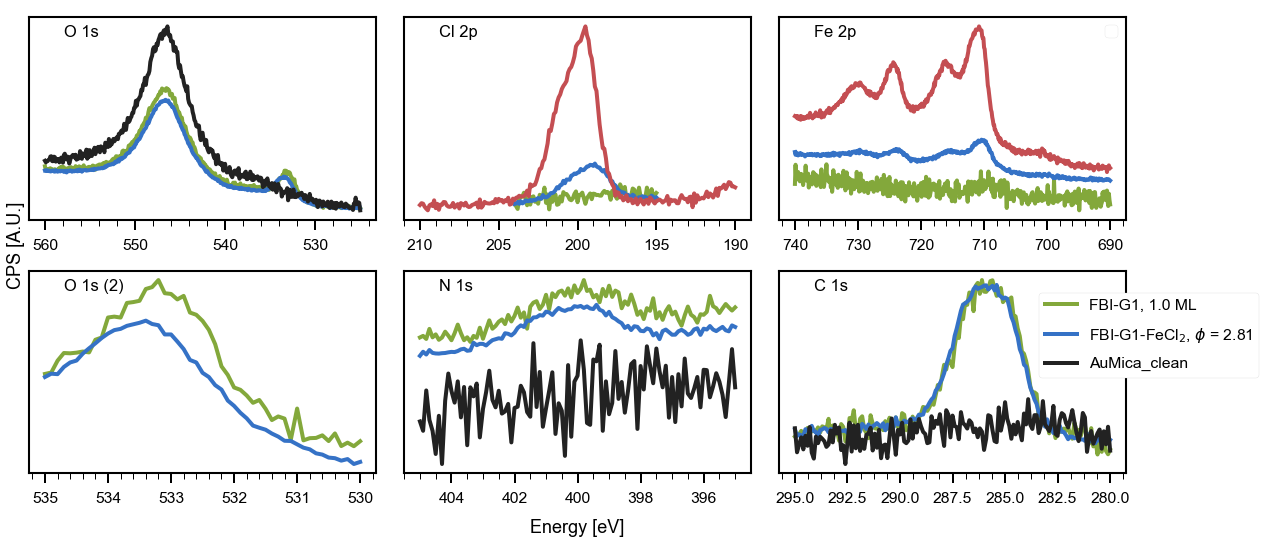

In [99]:
regs = [ 'O_1s', 'Cl_2p', 'Fe_2p', 'O_1s_(2)', 'N_1s', 'C_1s']

raw[0].name = 'FBI-G1, 1.0 ML'
raw[1].name = 'FBI-G1-FeCl$_2$, $\phi$ = 2.81'
raw[0].color = 'g'
raw[1].color = 'b'

ax = plot_xp_regions(raw , regs, ncols=3);
for a in ax:
    for i in a:
        i.invert_xaxis()
ax[1,0].invert_xaxis()

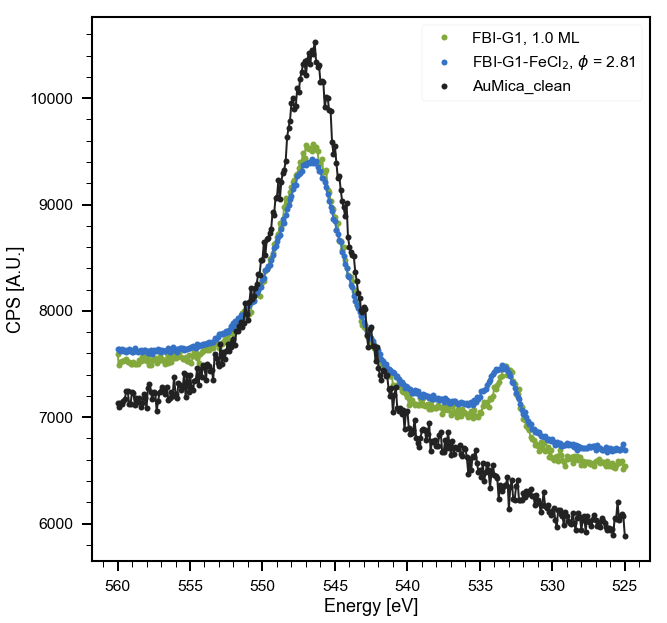

In [58]:
from matplotlib.colors import Normalize

region = 'O_1s'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6

plt.figure(figsize=(10,10))

blues = [10, 20, 30, 40, 60, 80]
off = [0, 150, -600, 300, 600]

for i,xp in enumerate(raw):
    scatter_region(xp, region, offset=off[i])
    plot_region(xp, region, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
ax.invert_xaxis()

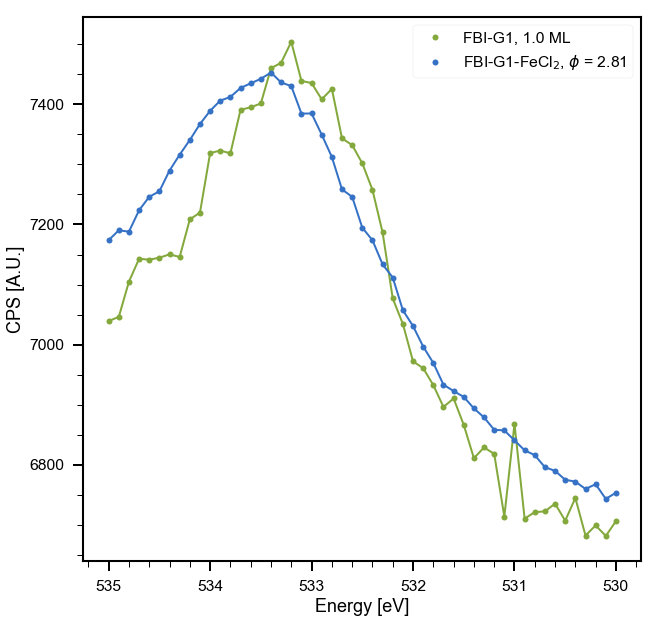

In [59]:
from matplotlib.colors import Normalize

region = 'O_1s_(2)'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6

plt.figure(figsize=(10,10))

blues = [10, 20, 30, 40, 60, 80]
off = [0, 150, -600, 300, 600]

for i,xp in enumerate(raw[:-1]):
    scatter_region(xp, region, offset=off[i])
    plot_region(xp, region, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
ax.invert_xaxis()

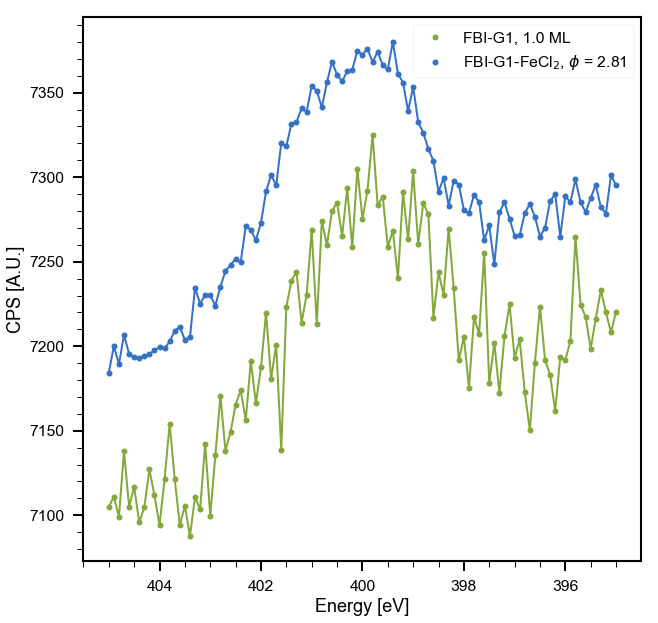

In [80]:
from matplotlib.colors import Normalize

region = 'N_1s'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6

plt.figure(figsize=(10,10))

blues = [10, 20, 30, 40, 60, 80]
off = [0, 150, -600, 300, 600]

for i,xp in enumerate(raw[:-1]):
    scatter_region(xp, region, offset=off[i])
    plot_region(xp, region, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
ax.invert_xaxis()

In [61]:
idxmax = np.argmax(raw[0].dfx[region].dropna().counts.values)
raw[0].dfx[region].energy.iloc[idxmax]

533.2

In [63]:
idxmax2 = np.argmax(raw[1].dfx[region].dropna().counts.values)
raw[1].dfx[region].energy.iloc[idxmax2]

533.4

KeyError in 'Fe_2p'


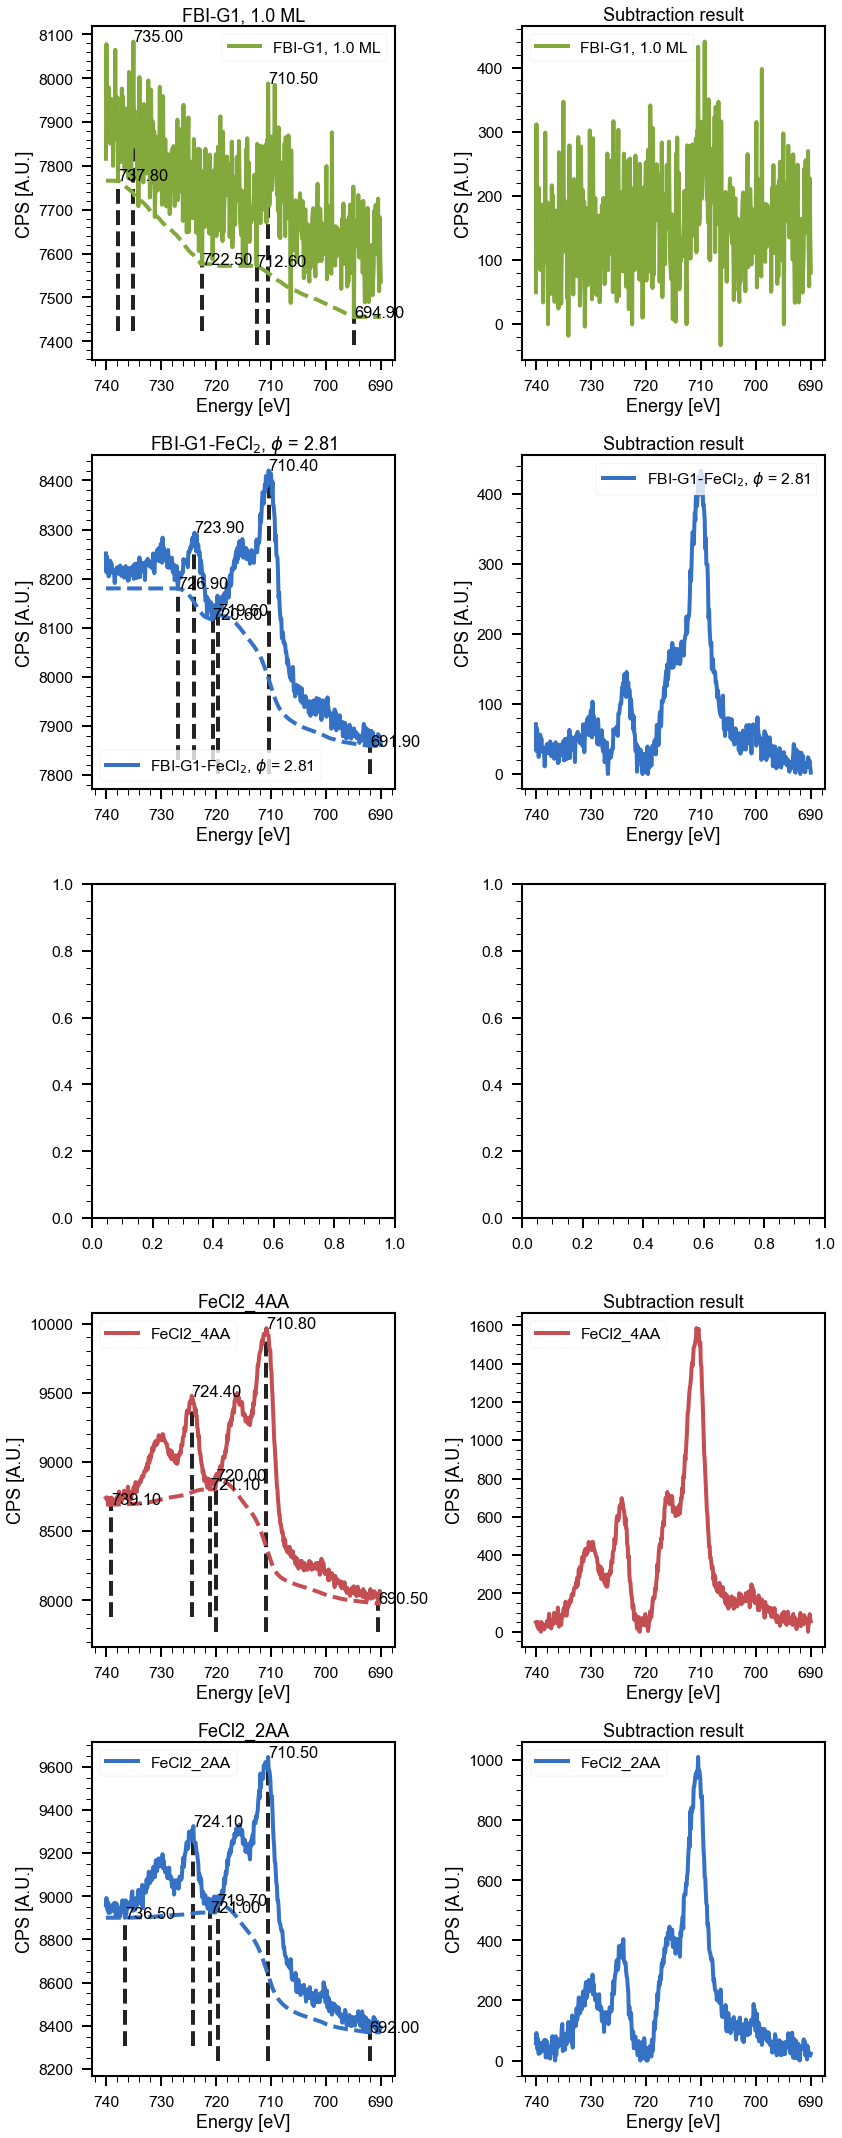

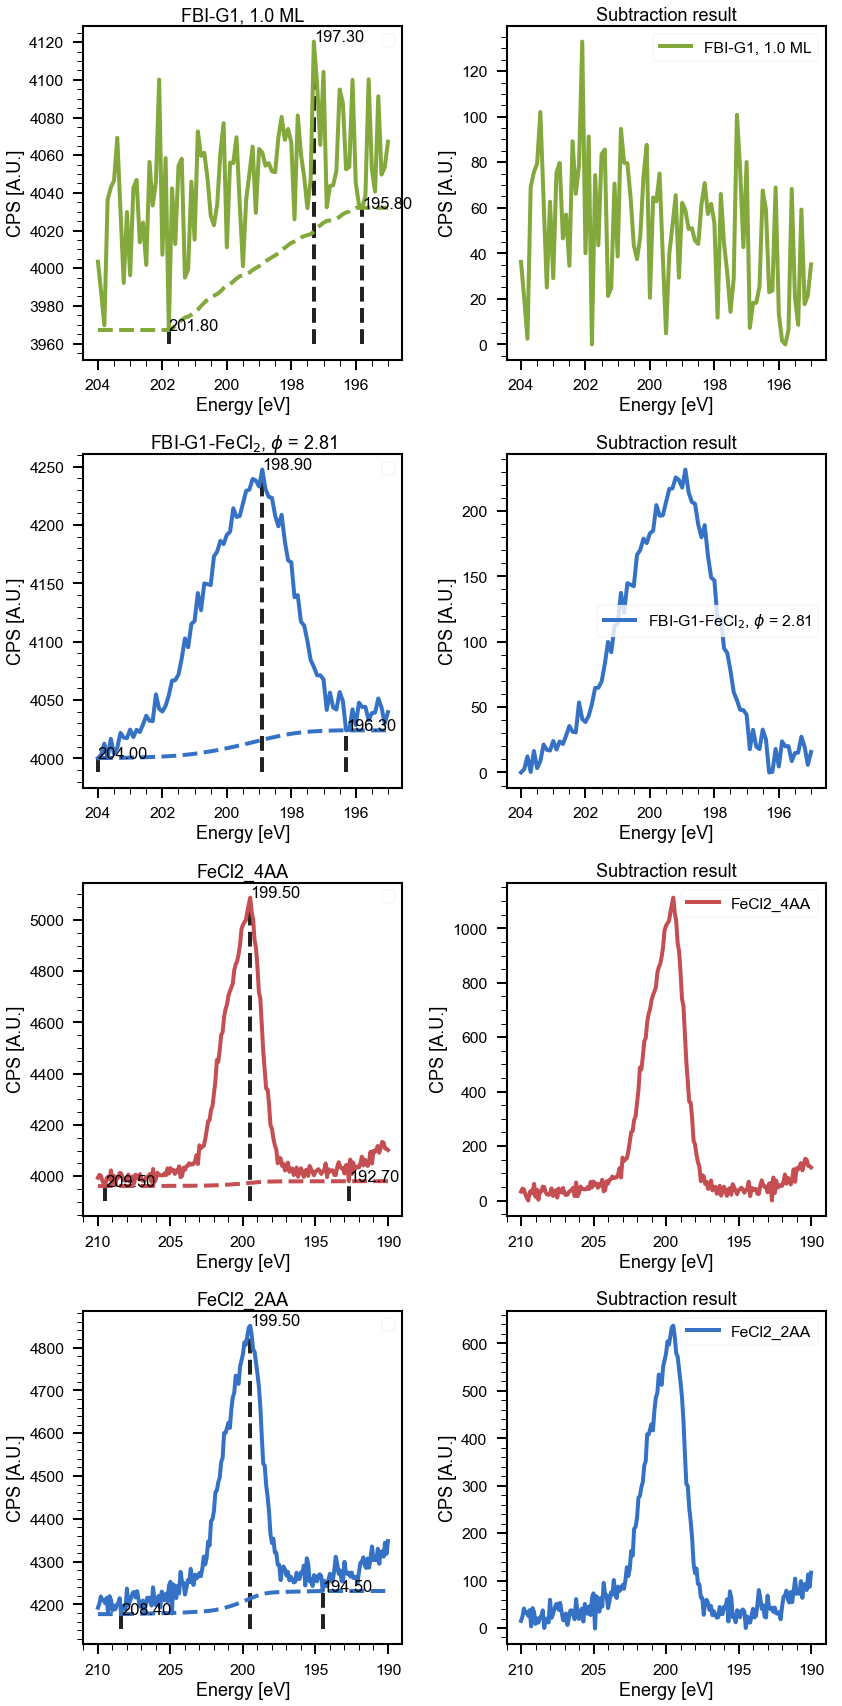

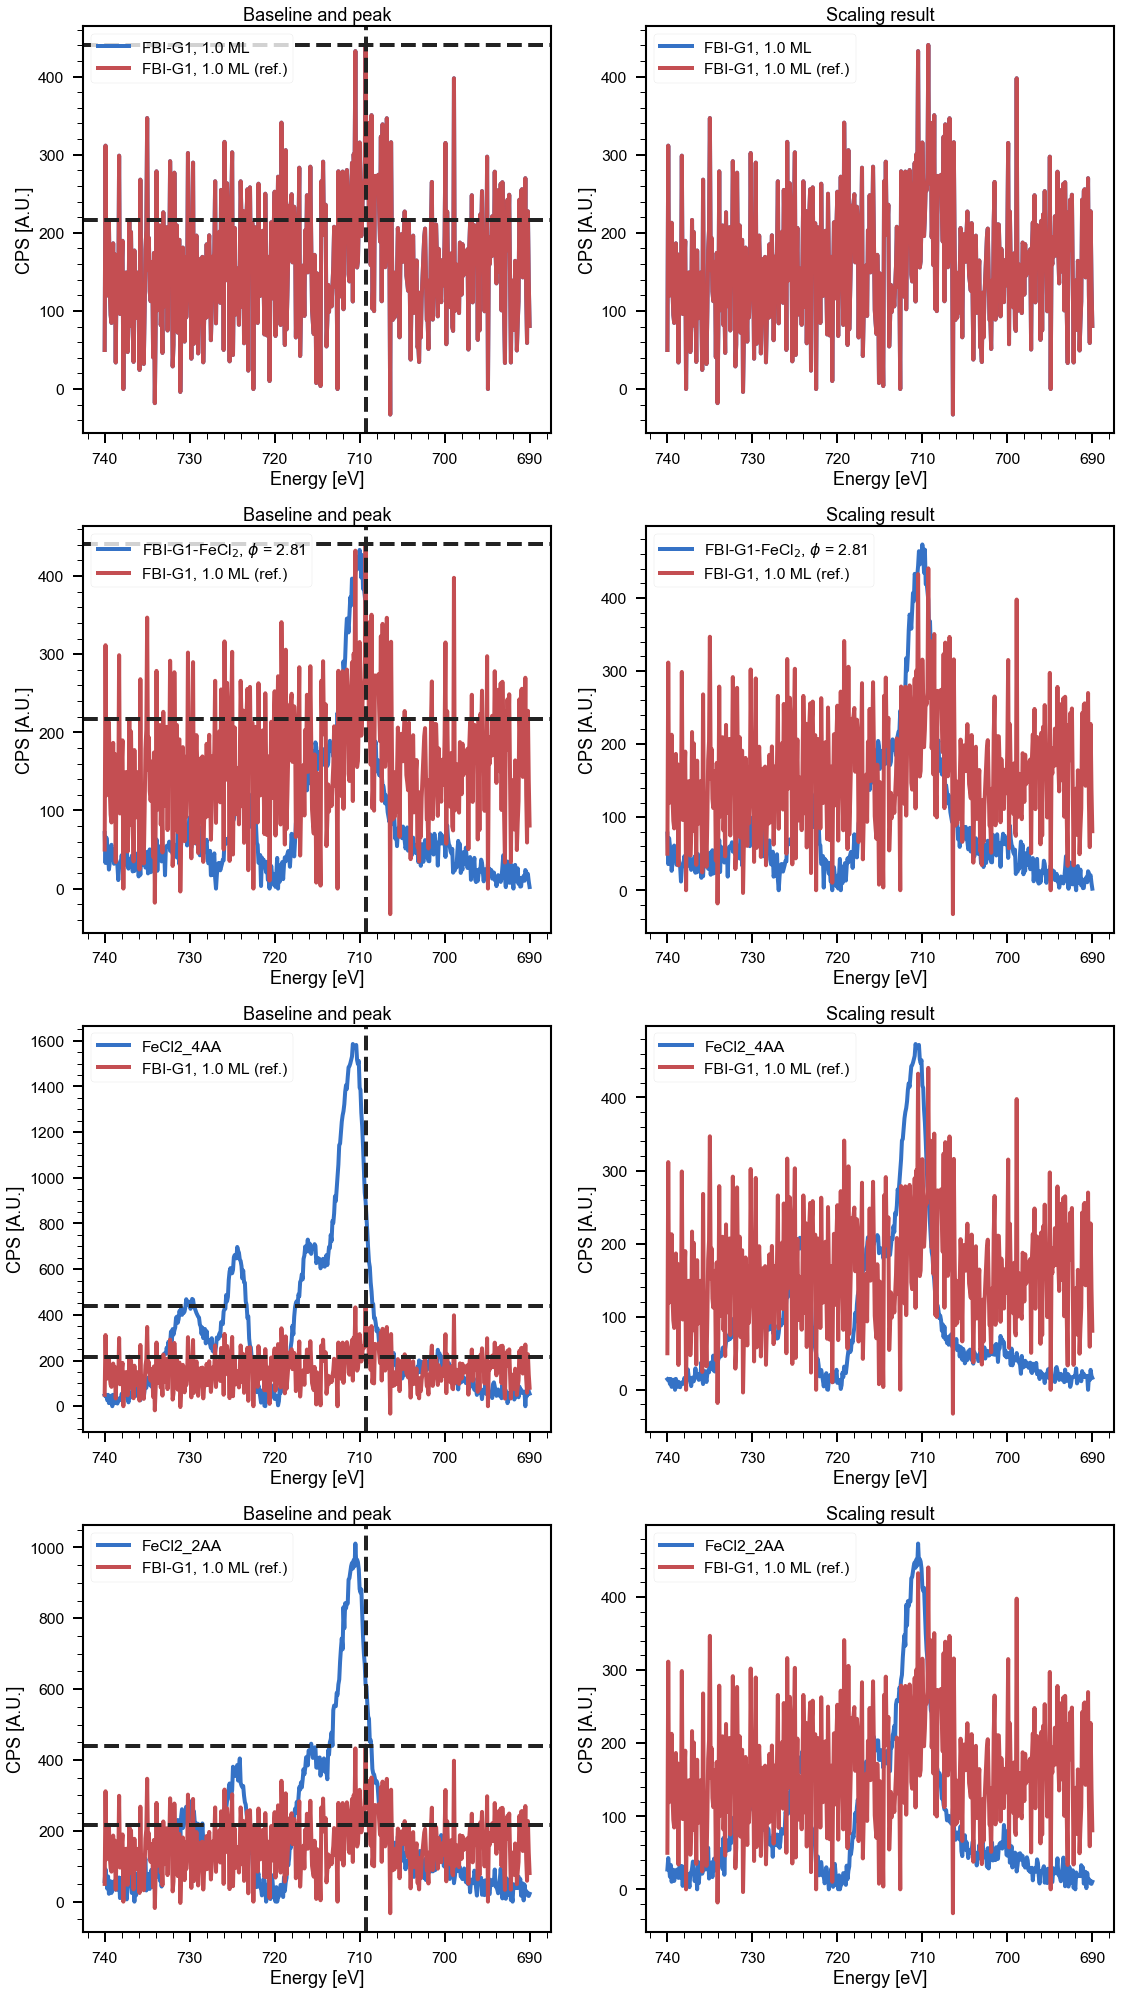

In [129]:
bg = region_2bg_subtract(raw, region='Fe_2p', xlim=720)
bg = region_bg_subtract(bg, region='Cl_2p')

norm = scale_and_plot_spectra(bg, region='Fe_2p')

In [133]:
[xp.name for xp in norm]

['FBI-G1, 1.0 ML',
 'FBI-G1-FeCl$_2$ 1 $\\AA$, $\\phi$ = 2.81',
 'FeCl$_2$ 2 $\\AA$',
 'FeCl2_2AA']

In [136]:
norm[1].name = 'FBI-G1-FeCl$_2$ 1 $\\AA$, $\\phi$ = 2.81'
norm[2].name = 'FeCl$_2$ 4 $\\AA$'
norm[3].name = 'FeCl$_2$ 2 $\\AA$'
norm[3].color = 'k'

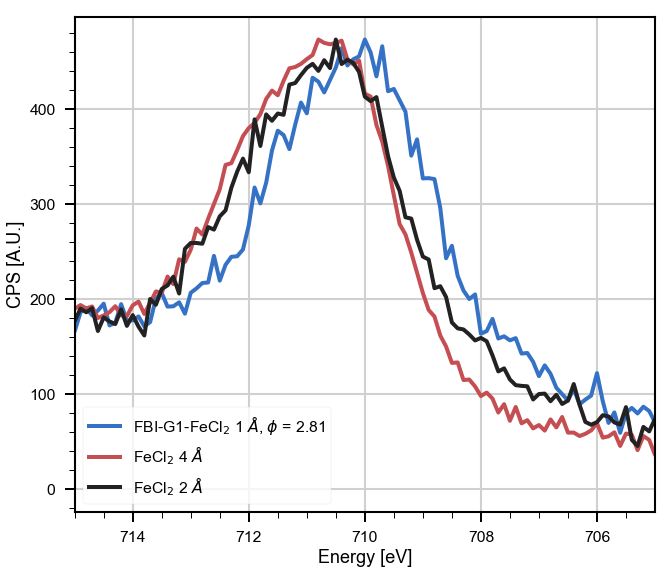

In [143]:
plot_region(norm[1], 'Fe_2p')
plot_region(norm[2], 'Fe_2p')
plot_region(norm[3], 'Fe_2p');
plt.gca().set(xlim=(715, 705));
plt.grid(True)

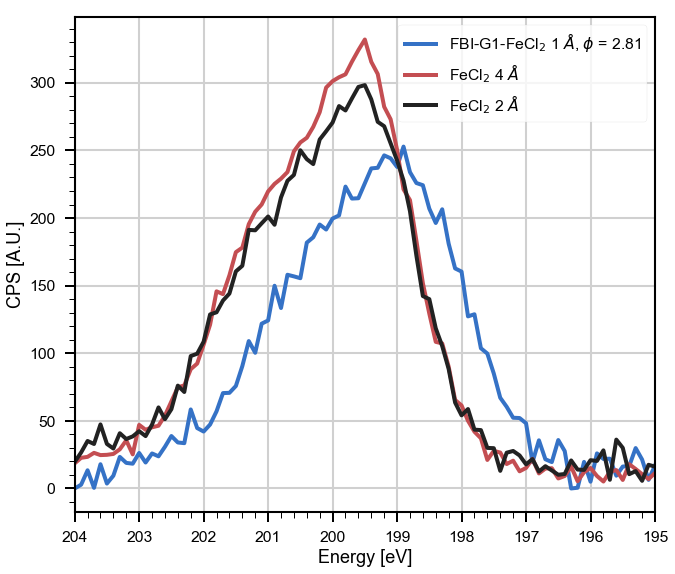

In [144]:
plot_region(norm[1], 'Cl_2p')
plot_region(norm[2], 'Cl_2p')
plot_region(norm[3], 'Cl_2p')
plt.gca().set(xlim=(204, 195));
plt.grid(True)